# Phase 3 Project
- author: Jonathan Holt
- Flatiron Data Science
- 7/19/21 Cohort

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed
plt.style.use('seaborn')

In [3]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Fixing column names

In [4]:
df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

# Inital Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

## 2/18/22

In [6]:
#churned_df_base = df[df["churn"] == 1]
#stayed_df_base = df[df["churn"] == 0]

In [7]:
#churned_df_base['account_length'].value_counts()

In [8]:
#stayed_df_base['customer_service_calls'].value_counts()

In [9]:
#churned_df_base[.value_counts()

In [10]:
#df.describe()

In [11]:
#df.isna().sum()

In [12]:
#df.churn.value_counts()

In [13]:
#df['number_vmail_messages'].value_counts()

# Cleaning and Preprocessing

In [14]:
#df.head()

In [15]:
test_df = df.copy()
test_df.head(2)

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


## Changing False to 0 and True to 1

In [16]:
test_df["churn"].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [17]:
test_df["churn"] = test_df["churn"].astype(int)

In [18]:
test_df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [19]:
#test_df = test_df.drop(columns=['state', 'phone_number', 'international_plan', 'voice_mail_plan'], axis=1)
test_df = test_df.drop(columns=['state','phone_number', 'area_code'], axis=1)

In [20]:
test_df.head(1)

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0


## Slicing out object type Features

In [21]:
cont_features = [col for col in test_df.columns if test_df[col].dtype in [np.float64, np.int64]]

In [22]:
cont_features

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls',
 'churn']

In [23]:
feature_df = test_df.loc[:, cont_features]
#X_test_cat = X_test.loc[:, features_cat]
feature_df

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,0
3329,68,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,0
3330,28,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,0
3331,184,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0


In [24]:
#need_to_encode = test_df[['area_code', 'customer_service_calls']]
need_to_encode = test_df[['international_plan', 'voice_mail_plan', 'customer_service_calls', 'churn']]

In [25]:
#IMPORTANT!
#Added 2/16 4PM. 
#feature_df = feature_df.drop(need_to_encode, axis=1)
#feature_df = feature_df.drop(['area_code', 'customer_service_calls'], axis=1)
#feature_df = feature_df.drop(['customer_service_calls'], axis=1)
#feature_df

## One Hot Encoding

In [26]:
ohe = OneHotEncoder()
ohe.fit(need_to_encode)

ohe_1 = ohe.transform(need_to_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
ohe_df.head()

,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9,churn_0,churn_1
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Dropping one value for categoricals

In [27]:
#IMPORTANT
#Dropping a few of the redundant values.
ohe_df = ohe_df.drop(['international_plan_no', 'voice_mail_plan_no', 'churn_0'], axis=1)
ohe_df.head()

,international_plan_yes,voice_mail_plan_yes,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9,churn_1
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
cs_calls_1_2_3_df=ohe_df[['customer_service_calls_1', 'customer_service_calls_2',
                          'customer_service_calls_3']]

In [29]:
cs_calls_1_2_3 = ohe_df.apply(lambda x: x['customer_service_calls_1'] + x['customer_service_calls_2']
                              + x['customer_service_calls_3'], axis=1)
cs_calls_4_5_6 = ohe_df.apply(lambda x: x['customer_service_calls_4'] + x['customer_service_calls_5']
                              + x['customer_service_calls_6'], axis=1)
cs_calls_7_8_9 = ohe_df.apply(lambda x: x['customer_service_calls_7'] + x['customer_service_calls_8']
                              + x['customer_service_calls_9'], axis=1)

ohe_df['cs_calls_1_2_3'] = cs_calls_1_2_3
ohe_df['cs_calls_4_5_6'] = cs_calls_4_5_6
ohe_df['cs_calls_7_8_9'] = cs_calls_7_8_9
ohe_df.head()

,international_plan_yes,voice_mail_plan_yes,customer_service_calls_0,customer_service_calls_1,customer_service_calls_2,customer_service_calls_3,customer_service_calls_4,customer_service_calls_5,customer_service_calls_6,customer_service_calls_7,customer_service_calls_8,customer_service_calls_9,churn_1,cs_calls_1_2_3,cs_calls_4_5_6,cs_calls_7_8_9
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [30]:
ohe_df = ohe_df.drop(['customer_service_calls_1','customer_service_calls_2','customer_service_calls_3',
                     'customer_service_calls_4','customer_service_calls_5','customer_service_calls_6',
                     'customer_service_calls_7','customer_service_calls_8','customer_service_calls_9']
                    , axis=1)
ohe_df.head()

,international_plan_yes,voice_mail_plan_yes,customer_service_calls_0,churn_1,cs_calls_1_2_3,cs_calls_4_5_6,cs_calls_7_8_9
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [31]:
# Combining everything together

cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)

In [33]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_length            3333 non-null   int64  
 1   number_vmail_messages     3333 non-null   int64  
 2   total_day_minutes         3333 non-null   float64
 3   total_day_calls           3333 non-null   int64  
 4   total_day_charge          3333 non-null   float64
 5   total_eve_minutes         3333 non-null   float64
 6   total_eve_calls           3333 non-null   int64  
 7   total_eve_charge          3333 non-null   float64
 8   total_night_minutes       3333 non-null   float64
 9   total_night_calls         3333 non-null   int64  
 10  total_night_charge        3333 non-null   float64
 11  total_intl_minutes        3333 non-null   float64
 12  total_intl_calls          3333 non-null   int64  
 13  total_intl_charge         3333 non-null   float64
 14  customer

In [34]:
#Dropping the categories that are now duplicates
cleaned_df = cleaned_df.drop(['churn', 'customer_service_calls'], axis=1)
cleaned_df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,total_intl_minutes,total_intl_calls,total_intl_charge,international_plan_yes,voice_mail_plan_yes,customer_service_calls_0,churn_1,cs_calls_1_2_3,cs_calls_4_5_6,cs_calls_7_8_9
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,10.0,3,2.70,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,13.7,3,3.70,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,12.2,5,3.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,6.6,7,1.78,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,10.1,3,2.73,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
#X = cleaned_df.drop(['churn'], axis=1)
X = cleaned_df.drop(['churn_1'], axis=1)
#X = test_df[['area_code', 'international_plan', 'voice_mail_plan', 'customer_service_calls' ]]
#y = cleaned_df['churn']
y = cleaned_df['churn_1']

## Train-Test Split

In [36]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=23)

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2499 entries, 978 to 595
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_length            2499 non-null   int64  
 1   number_vmail_messages     2499 non-null   int64  
 2   total_day_minutes         2499 non-null   float64
 3   total_day_calls           2499 non-null   int64  
 4   total_day_charge          2499 non-null   float64
 5   total_eve_minutes         2499 non-null   float64
 6   total_eve_calls           2499 non-null   int64  
 7   total_eve_charge          2499 non-null   float64
 8   total_night_minutes       2499 non-null   float64
 9   total_night_calls         2499 non-null   int64  
 10  total_night_charge        2499 non-null   float64
 11  total_intl_minutes        2499 non-null   float64
 12  total_intl_calls          2499 non-null   int64  
 13  total_intl_charge         2499 non-null   float64
 14  interna

# Decision Tree 1 (Baseline Decision Tree)

In [38]:
dtree_1 = DecisionTreeClassifier(random_state=23)

dtree_1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=23)

In [39]:
dt1_y_pred = dtree_1.predict(X_test)

## Evaluatiing Decision Tree 1

In [40]:
# Calculate accuracy 
dt1_acc = accuracy_score(y_test, dt1_y_pred) * 100
print('DTree 1 Accuracy is :{0}'.format(dt1_acc))

DTree 1 Accuracy is :91.00719424460432


In [41]:
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt1_y_pred)
dt1_roc_auc = auc(false_positive_rate, true_positive_rate)
print('\n DTree 1 AUC is :{0}'.format(round(dt1_roc_auc, 2)))


 DTree 1 AUC is :0.84


In [42]:
# Create and print a confusion matrix 
print('\n DTree 1 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, dt1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


 DTree 1 Confusion Matrix
----------------


Predicted,0.0,1.0,All
True,,,
0.0,665,43,708
1.0,32,94,126
All,697,137,834


## Analysis of Accuracy, AUC, and Confusion Matrix
- Analysis goes HERE
- AND HERE
- AND HERE!

In [43]:
#dt1_cv_score = cross_val_score(dtree_1, X_train, y_train, cv=3)
#mean_dt1_cv_score = np.mean(dt1_cv_score)

#print(f"DTree 1 Mean Cross Validation Score: {mean_dt1_cv_score :.2%}")

## Plot

In [44]:
# ENTER PLOT CODE HERE!

# GridSearchCV & Decision Tree 2

In [45]:
dtree_2 = DecisionTreeClassifier(random_state=23)

In [46]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [47]:
# Instantiate GridSearchCV
dt2_grid_search = GridSearchCV(dtree_2, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt2_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=23),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [48]:
# Mean training score
dt2_gs_training_score = np.mean(dt2_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt2_gs_testing_score = dt2_grid_search.score(X_test, y_test)

print(f"DTree 2 Mean Training Score: {dt2_gs_training_score :.2%}")
print(f"DTree 2 Mean Test Score: {dt2_gs_testing_score :.2%}")
print("DTree 2 Best Parameter Combination Found During Grid Search:")
dt2_grid_search.best_params_

DTree 2 Mean Training Score: 93.36%
DTree 2 Mean Test Score: 94.36%
DTree 2 Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

## Decision Tree 2

In [49]:
#dtree_2 = DecisionTreeClassifier(criterion='entropy', 
#                           max_depth=6,
#                           min_samples_split=2,
#                           min_samples_leaf=6,
#                            random_state=23)

In [50]:
dtree_2 = DecisionTreeClassifier(criterion='gini', 
                           max_depth=6,
                           min_samples_split=2,
                           min_samples_leaf=1,
                            random_state=23)

In [51]:
dtree_2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=23)

In [52]:
dt2_y_pred = dtree_2.predict(X_test)

## Evaluating Decision Tree 2

In [53]:
# Calculate accuracy 
dt2_acc = accuracy_score(y_test,dt2_y_pred) * 100
print('DTree 2 Accuracy is :{0}'.format(dt2_acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt2_y_pred)
dt2_roc_auc = auc(false_positive_rate, true_positive_rate)
print('DTree 2 AUC is :{0}'.format(round(dt2_roc_auc, 2)))

# Create and print a confusion matrix 
print('DTree 2 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, dt2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

DTree 2 Accuracy is :94.36450839328538
DTree 2 AUC is :0.84
DTree 2 Confusion Matrix
----------------


Predicted,0.0,1.0,All
True,,,
0.0,699,9,708
1.0,38,88,126
All,737,97,834


## Analysis of Accuracy, AUC, and Confusion Matrix
- Analysis goes HERE
- AND HERE
- AND HERE!

## Plot?

# Random Forests 1

In [54]:
rf1_clf = RandomForestClassifier(random_state=23)
mean_rf1_cv_score = np.mean(cross_val_score(rf1_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf1_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 94.40%


In [55]:
rf1_clf.fit(X_train, y_train)
rf1_y_pred = rf1_clf.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,rf1_y_pred)
rf1_roc_auc = auc(false_positive_rate, true_positive_rate)
rf1_roc_auc
print(f"Random Forests 1 AUC Score: {rf1_roc_auc :.2%}")

Random Forests 1 AUC Score: 84.68%


## Evaluating Random Forests 1

In [56]:
# Calculate accuracy 
rf1_acc = accuracy_score(y_test,rf1_y_pred) * 100
print('Random Forests 1 Accuracy is :{0}'.format(rf1_acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf1_y_pred)
rf1_roc_auc = auc(false_positive_rate, true_positive_rate)
print('Random Forests 1 AUC is :{0}'.format(round(rf1_roc_auc, 2)))

# Create and print a confusion matrix 
print('Random Forests Confusion Matrix')
print('----------------')
pd.crosstab(y_test, rf1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Random Forests 1 Accuracy is :94.48441247002398
Random Forests 1 AUC is :0.85
Random Forests Confusion Matrix
----------------


Predicted,0.0,1.0,All
True,,,
0.0,699,9,708
1.0,37,89,126
All,736,98,834


# GridSearch_CV & Random Forests 2

In [57]:
rf2_clf = RandomForestClassifier(random_state=23)

In [58]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [59]:
rf2_grid_search = GridSearchCV(rf2_clf, rf_param_grid, cv=3)
rf2_grid_search.fit(X_train, y_train)

print(f"Random Forest 2 Training Accuracy: {rf2_grid_search.best_score_ :.2%}")
print("")
# Mean test score
rf2_gs_testing_score = rf2_grid_search.score(X_test, y_test)
print("")
print(f"Random Forest 2 Optimal Parameters: {rf2_grid_search.best_params_}")

Random Forest 2 Training Accuracy: 94.12%


Random Forest 2 Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


In [60]:
print(f"Random Forests 2 Mean Test Score: {rf2_gs_testing_score :.2%}")

Random Forests 2 Mean Test Score: 94.36%


In [61]:
#rf2_clf = RandomForestClassifier(criterion= 'entropy',
#                                max_depth= None,
#                                min_samples_leaf= 3,
#                                min_samples_split= 5,
#                                n_estimators= 100)

#mean_rf2_cv_score = np.mean(cross_val_score(rf2_clf, X_train, y_train, cv=3))

#print(f"Random Forests 2 Mean Cross Validation Score: {mean_rf2_cv_score :.2%}")

In [62]:
rf2_clf = RandomForestClassifier(criterion= 'gini',
                                max_depth= None,
                                min_samples_leaf= 3,
                                min_samples_split= 5,
                                n_estimators= 100)

mean_rf2_cv_score = np.mean(cross_val_score(rf2_clf, X_train, y_train, cv=3))

print(f"Random Forests 2 Mean Cross Validation Score: {mean_rf2_cv_score :.2%}")

Random Forests 2 Mean Cross Validation Score: 93.72%


In [63]:
rf2_clf.fit(X_train, y_train)
rf2_y_pred = rf2_clf.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,rf2_y_pred)
rf2_roc_auc = auc(false_positive_rate, true_positive_rate)
rf2_roc_auc
print(f"Random Forests 2 AUC Score: {rf2_roc_auc :.2%}")

Random Forests 2 AUC Score: 84.61%


## Evaluating Random Forests 2

In [64]:
# Calculate accuracy 
rf2_acc = accuracy_score(y_test,rf2_y_pred) * 100
print('Random Forests 2 Accuracy is :{0}'.format(rf2_acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf2_y_pred)
rf2_roc_auc = auc(false_positive_rate, true_positive_rate)
print('Random Forests 2 AUC is :{0}'.format(round(rf2_roc_auc, 2)))

# Create and print a confusion matrix 
print('Random Forests 2 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, rf2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Random Forests 2 Accuracy is :94.36450839328538
Random Forests 2 AUC is :0.85
Random Forests 2 Confusion Matrix
----------------


Predicted,0.0,1.0,All
True,,,
0.0,698,10,708
1.0,37,89,126
All,735,99,834


In [65]:
dt2_score = dt2_grid_search.score(X_test, y_test)
rf2_score = rf2_grid_search.score(X_test, y_test)

print('Decision tree 2 grid search Score: ', dt2_score)
print('Random forest 2 grid search Score: ', rf2_score)

Decision tree 2 grid search Score:  0.9436450839328537
Random forest 2 grid search Score:  0.9436450839328537


# Comparisons

In [66]:
# Accuracy Score, AUC, & Confusion Matrix
print('DTree 1 Accuracy is :{0}'.format(dt1_acc))
print('DTree 1 AUC is :{0}'.format(round(dt1_roc_auc, 2)))
print('--------------------------------')
print('DTree 2 Accuracy is :{0}'.format(dt2_acc))
print('DTree 2 AUC is :{0}'.format(round(dt2_roc_auc, 2)))
print('--------------------------------')
print('Random Forests 1 Accuracy is :{0}'.format(rf1_acc))
print('Random Forests 1 AUC is :{0}'.format(round(rf1_roc_auc, 2)))
print('--------------------------------')
print('Random Forests 2 Accuracy is :{0}'.format(rf2_acc))
print('Random Forests 2 AUC is :{0}'.format(round(rf2_roc_auc, 2)))

DTree 1 Accuracy is :91.00719424460432
DTree 1 AUC is :0.84
--------------------------------
DTree 2 Accuracy is :94.36450839328538
DTree 2 AUC is :0.84
--------------------------------
Random Forests 1 Accuracy is :94.48441247002398
Random Forests 1 AUC is :0.85
--------------------------------
Random Forests 2 Accuracy is :94.36450839328538
Random Forests 2 AUC is :0.85


In [67]:
print('\n DTree 1 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, dt1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('DTree 2 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, dt2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
print('Random Forests 1 Confusion Matrix')
print('----------------')
print(pd.crosstab(y_test, rf1_y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('----------------')
print('----------------')
# Create and print a confusion matrix 
print('Random Forests 2 Confusion Matrix')
print('----------------')
pd.crosstab(y_test, rf2_y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


 DTree 1 Confusion Matrix
----------------
Predicted  0.0  1.0  All
True                    
0.0        665   43  708
1.0         32   94  126
All        697  137  834
----------------
----------------
DTree 2 Confusion Matrix
----------------
Predicted  0.0  1.0  All
True                    
0.0        699    9  708
1.0         38   88  126
All        737   97  834
----------------
----------------
Random Forests 1 Confusion Matrix
----------------
Predicted  0.0  1.0  All
True                    
0.0        699    9  708
1.0         37   89  126
All        736   98  834
----------------
----------------
Random Forests 2 Confusion Matrix
----------------


Predicted,0.0,1.0,All
True,,,
0.0,698,10,708
1.0,37,89,126
All,735,99,834


In [68]:
#Comparing the Tuned Models
print(f"DTree 2 Mean Training Score: {dt2_gs_training_score :.2%}")
print(f"DTree 2 Mean Test Score: {dt2_gs_testing_score :.2%}")
print('--------------------------------')
print(f"Random Forest 2 Training Accuracy: {rf2_grid_search.best_score_ :.2%}")
print(f"Random Forest 2 Mean Test Score: {rf2_gs_testing_score :.2%}")

DTree 2 Mean Training Score: 93.36%
DTree 2 Mean Test Score: 94.36%
--------------------------------
Random Forest 2 Training Accuracy: 94.12%
Random Forest 2 Mean Test Score: 94.36%


In [69]:
#print(f"DTree 1 Mean Cross Validation Score: {mean_dt1_cv_score :.2%}")
#print(f"DTree 1 Mean Training Score: {dt1_gs_training_score :.2%}")
#print(f"DTree 1 Mean Test Score: {dt1_gs_testing_score :.2%}")
#print('Decision tree 1 grid search Score: ', dt1_score)
#print(f"DTree 1 AUC Score: {dt1_roc_auc :.2%}")
print('--------------------------------')
#print(f"RandomForest 1 Mean Cross Validation Score: {mean_rf1_cv_score :.2%}")
#print(f"Random Forest 1 Training Accuracy: {rf1_grid_search.best_score_ :.2%}")
#print('Random forest 1 grid search Score: ', rf1_score)
#print(f"Random Forests 1 AUC Score: {rf1_roc_auc :.2%}")
print('--------------------------------')
#print(f"DTree 2 Mean Cross Validation Score: {mean_dt2_cv_score :.2%}")
print('--------------------------------')
#print(f"Random Forests 2 Mean Cross Validation Score: {mean_rf2_cv_score :.2%}")


--------------------------------
--------------------------------
--------------------------------


### Analysis:
    - Explain what cross validation score means
    - explain what training score means
    - explain what test score means
    - explain what grid search score means
    - explain what ROC AUC score means

## Optimal Parameters

In [70]:
print("DTree 2 Best Parameter Combination Found During Grid Search:")
dt2_grid_search.best_params_

DTree 2 Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

In [71]:
print(f"Random Forest 1 Optimal Parameters: {rf2_grid_search.best_params_}")

Random Forest 1 Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


# Feature Importance

## Currently set to analyze Random Forests 2

In [72]:
feature_names = list(X)
feature_names

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'international_plan_yes',
 'voice_mail_plan_yes',
 'customer_service_calls_0',
 'cs_calls_1_2_3',
 'cs_calls_4_5_6',
 'cs_calls_7_8_9']

In [73]:
rf2_importance = rf2_clf.feature_importances_
rf2_importance

array([0.02706115, 0.02471921, 0.13856726, 0.02466568, 0.16745305,
       0.06197387, 0.02445925, 0.05891778, 0.02922723, 0.02823193,
       0.03000313, 0.04163978, 0.04965317, 0.04535782, 0.09191104,
       0.02388747, 0.02349909, 0.0160883 , 0.08194276, 0.01074105])

In [74]:
feature_importance_df = pd.DataFrame(rf2_importance, feature_names)
feature_importance_df

,0
account_length,0.027061
number_vmail_messages,0.024719
total_day_minutes,0.138567
total_day_calls,0.024666
total_day_charge,0.167453
total_eve_minutes,0.061974
total_eve_calls,0.024459
total_eve_charge,0.058918
total_night_minutes,0.029227
total_night_calls,0.028232


In [75]:
feature_importance_df= feature_importance_df.reset_index()

In [76]:
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df

,Feature,Importance
0,account_length,0.027061
1,number_vmail_messages,0.024719
2,total_day_minutes,0.138567
3,total_day_calls,0.024666
4,total_day_charge,0.167453
5,total_eve_minutes,0.061974
6,total_eve_calls,0.024459
7,total_eve_charge,0.058918
8,total_night_minutes,0.029227
9,total_night_calls,0.028232


In [77]:
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
4,total_day_charge,0.167453
2,total_day_minutes,0.138567
14,international_plan_yes,0.091911
18,cs_calls_4_5_6,0.081943
5,total_eve_minutes,0.061974
7,total_eve_charge,0.058918
12,total_intl_calls,0.049653
13,total_intl_charge,0.045358
11,total_intl_minutes,0.041640
10,total_night_charge,0.030003


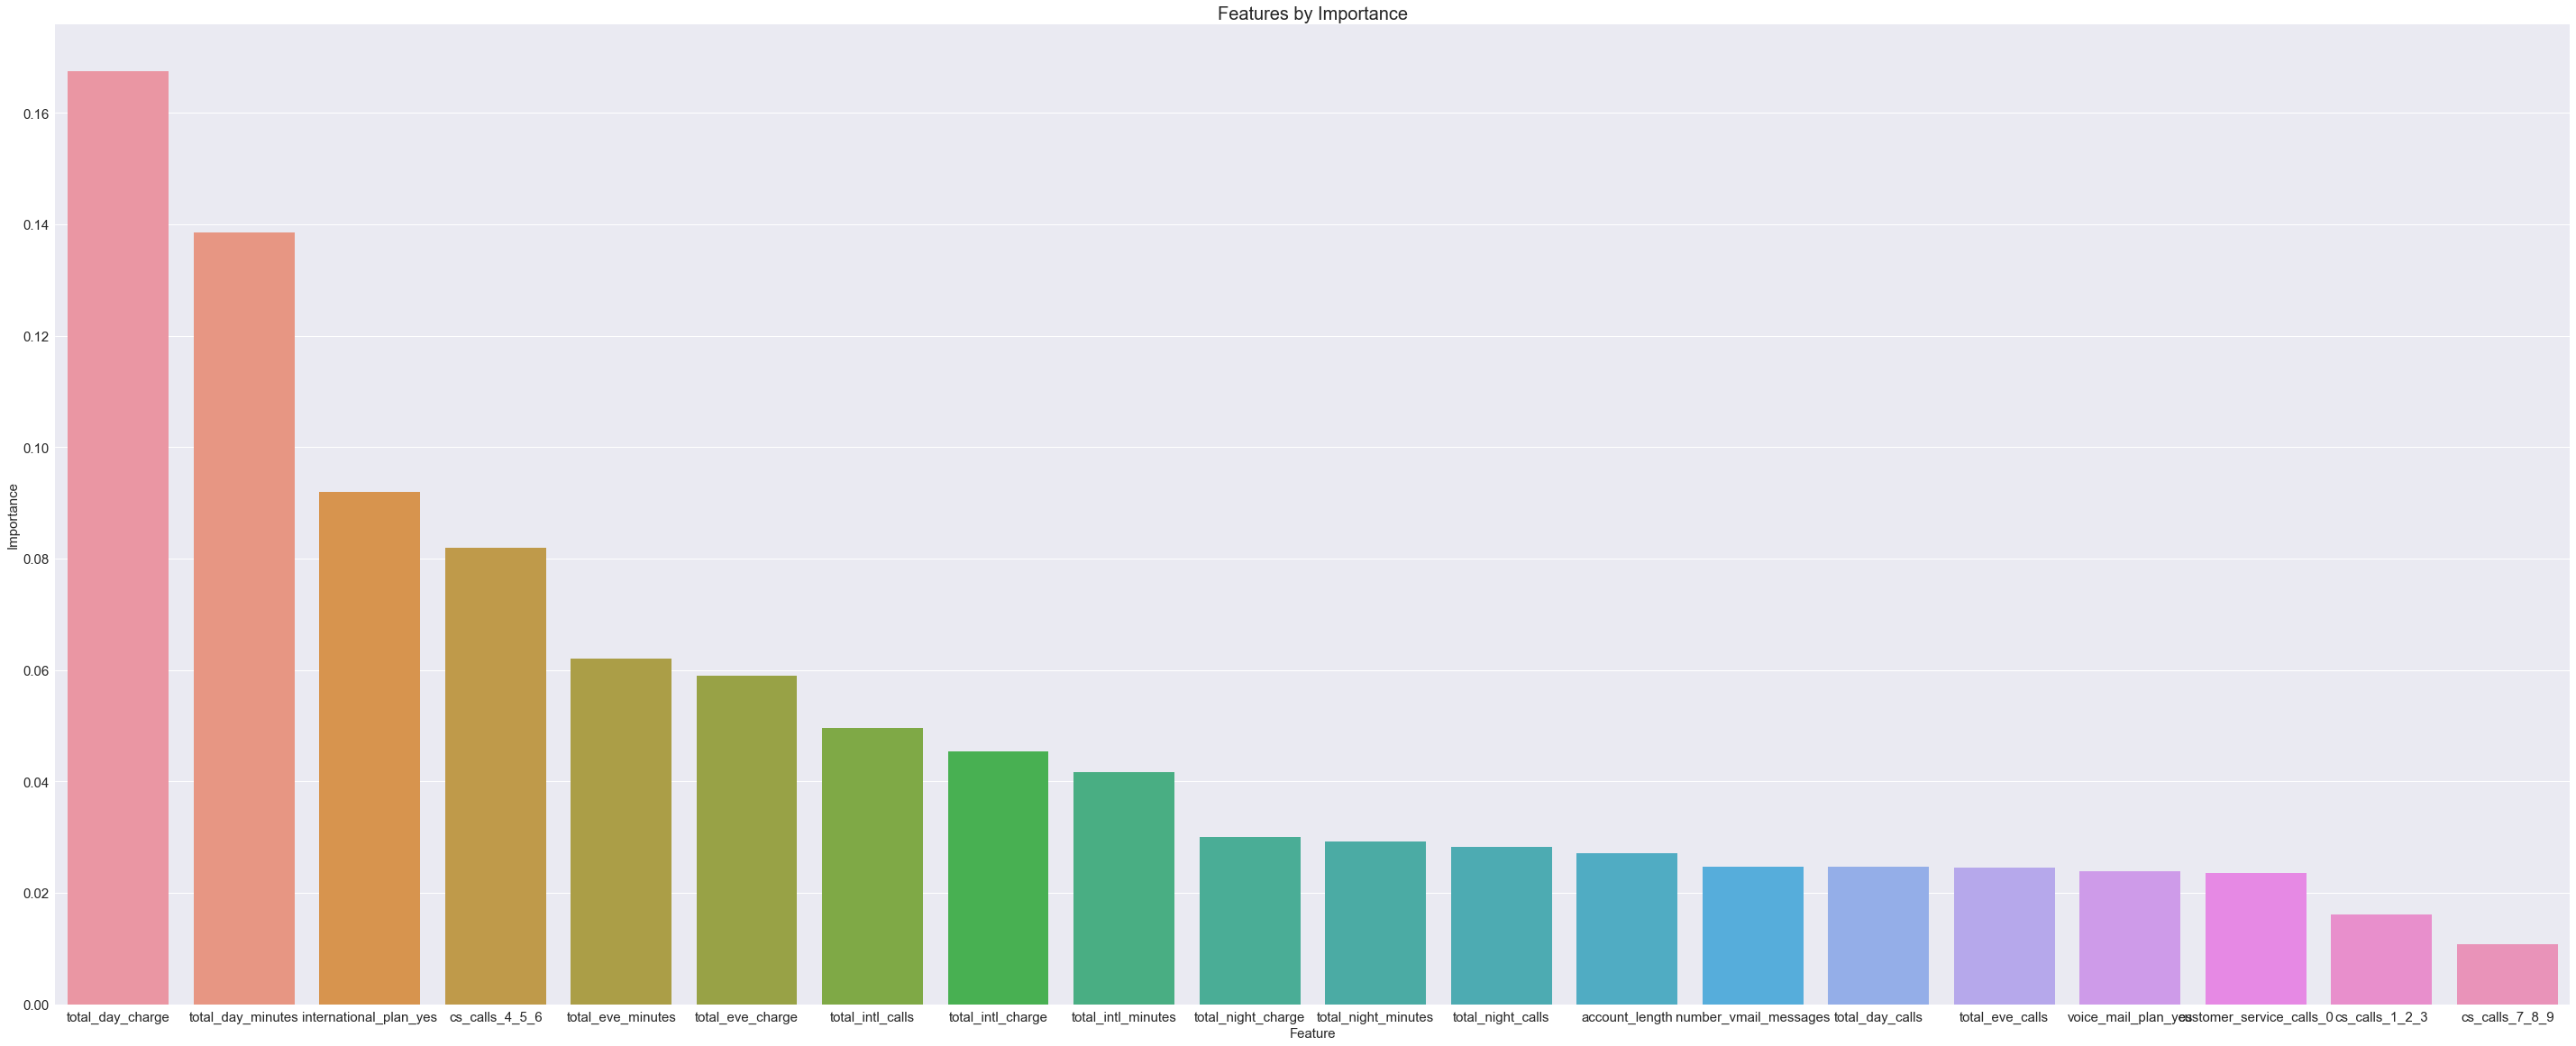

In [78]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,20))
p = sns.barplot(data=feature_importance_df, x='Feature', y='Importance' );

p.set_xlabel("Feature", fontsize = 15)

p.set_ylabel("Importance", fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#p.yaxis.set_major_formatter(display_millions)
p.set_title("Features by Importance", fontsize = 20)
plt.figsize=(30,20) 
#plt.savefig('images/project_1_bar_3')

plt.show();

In [79]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   account_length            3333 non-null   int64  
 1   number_vmail_messages     3333 non-null   int64  
 2   total_day_minutes         3333 non-null   float64
 3   total_day_calls           3333 non-null   int64  
 4   total_day_charge          3333 non-null   float64
 5   total_eve_minutes         3333 non-null   float64
 6   total_eve_calls           3333 non-null   int64  
 7   total_eve_charge          3333 non-null   float64
 8   total_night_minutes       3333 non-null   float64
 9   total_night_calls         3333 non-null   int64  
 10  total_night_charge        3333 non-null   float64
 11  total_intl_minutes        3333 non-null   float64
 12  total_intl_calls          3333 non-null   int64  
 13  total_intl_charge         3333 non-null   float64
 14  internat

## Analysis
- Figure out how to rank feature importance as this is the ultimate outcome for my business problem.
- VISUALIZE!!!!

# Analysis of Churned Customers

In [80]:
churned_df = cleaned_df[cleaned_df["churn"] == 1]
churned_df

KeyError: 'churn'

In [ ]:
churned_df.info()

In [ ]:
churn_means = churned_df.mean()

In [ ]:
stayed_df = cleaned_df[cleaned_df["churn"] == 0]
stayed_df

In [ ]:
stayed_means = stayed_df.mean()

In [ ]:
stayed_means = stayed_means.reset_index()

In [ ]:
churn_means = churn_means.reset_index()

In [ ]:
new_df = pd.merge(stayed_means, churn_means, on= 'index')
new_df.head()

In [ ]:
new_df

# Plot Decision Tree

## Analysis:
    - A plot of a Decision Tree might make fore a nice visual.

# Archive